# Model_1

In [1]:
%load_ext tensorboard
import tensorflow as tf
import datetime

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
 
import string
import matplotlib.pyplot as plt
import seaborn as sns
  
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
 
import pickle
from tqdm import tqdm
import os

In [3]:
from numpy import asarray
from numpy import zeros
from sklearn import preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#data=pd.read_csv('LSTM_data.csv',nrows=60000)
data=pd.read_csv('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/LSTM_data.csv',nrows=60000)
print(data.columns)
print(data.shape)
data.head(5)

Index(['essay', 'project_resource_summary', 'project_title',
       'project_grade_category', 'project_subject_categories',
       'teacher_prefix', 'project_subject_subcategories', 'school_state',
       'std_teacher_number_of_previously_posted_projects', 'std_price',
       'std_quantity', 'presence of the numerical digits',
       'project_is_approved'],
      dtype='object')
(60000, 13)


,essay,project_resource_summary,project_title,project_grade_category,project_subject_categories,teacher_prefix,project_subject_subcategories,school_state,std_teacher_number_of_previously_posted_projects,std_price,std_quantity,presence of the numerical digits,project_is_approved
0,students english learners working english seco...,students need opportunities practice beginning...,educational support english learners home,grades_prek_2,literacy_language,mrs,esl literacy,in,-0.401525,-0.390533,0.230471,0,0
1,students arrive school eager learn polite gene...,students need projector help viewing education...,wanted projector hungry learners,grades_6_8,history_civics health_sports,mr,civics_government teamsports,fl,-0.149518,0.002396,-0.609774,0,1
2,true champions not always ones win guts mia ha...,students need shine guards athletic socks socc...,soccer equipment awesome middle school students,grades_6_8,health_sports,ms,health_wellness teamsports,az,-0.365524,0.595191,0.192278,0,0
3,work unique school filled esl english second l...,students need engage reading math way inspire ...,techie kindergarteners,grades_prek_2,literacy_language math_science,mrs,literacy mathematics,ky,-0.257521,-0.177469,-0.495195,0,1
4,second grade classroom next year made around 2...,students need hands practice mathematics fun p...,interactive math tools,grades_prek_2,math_science,mrs,mathematics,tx,-0.365524,-0.626236,-0.495195,0,1


In [6]:
data['project_title']=data['project_title'].fillna('nan')
data['total_text_data']=data['project_title']+' '+data['project_resource_summary']+' '+data['essay']

In [7]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6, stratify=y,random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(45000, 13) (45000,)
(10000, 13) (10000,)
(5000, 13) (5000,)


# **Vectorize text data**

In [8]:
X_train_text=X_train['total_text_data']
X_test_text=X_test['total_text_data']
X_cv_text=X_cv['total_text_data']
print(X_train_text.shape,y_train.shape)
print(X_test_text.shape,y_test.shape)
print(X_cv_text.shape,y_test.shape)

(45000,) (45000,)
(10000,) (10000,)
(5000,) (10000,)


In [9]:
X_train_text[0]

'educational support english learners home students need opportunities practice beginning reading skills english home students english learners working english second third languages melting pot refugees immigrants native born americans bringing gift language school 24 languages represented english learner program students every level mastery also 40 countries represented families within school student brings wealth knowledge experiences us open eyes new cultures beliefs respect limits language limits world ludwig wittgenstein english learner strong support system home begs resources many times parents learning read speak english along side children sometimes creates barriers parents able help child learn phonetics letter recognition reading skills providing dvd players students able continue mastery english language even no one home able assist families students within level 1 proficiency status offered part program educational videos specially chosen english learner teacher sent home

In [10]:
X_train_text = X_train_text.astype(str)#tokenize on training reviews reviews
X_test_text = X_test_text.astype(str)#tokenize on test reviews reviews
X_cv_text = X_cv_text.astype(str)
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_text)
vocab_size_text = len(t.word_index) + 1
# integer encode the documents
X_train_text = t.texts_to_sequences(X_train_text)
X_test_text = t.texts_to_sequences(X_test_text)
X_cv_text = t.texts_to_sequences(X_cv_text)

# pad documents to a max length
#max_len=max([len(s.split()) for s in X_train_text])
max_len_text=max([len(s) for s in X_train_text])
X_train_text = pad_sequences(X_train_text, maxlen=max_len_text, padding='post')
X_test_text = pad_sequences(X_test_text, maxlen=max_len_text, padding='post')
X_cv_text = pad_sequences(X_cv_text, maxlen=max_len_text, padding='post')

print('shape of X_train_text ',X_train_text.shape)
print('shape of X_test_text ',X_test_text.shape)
print('shape of X_cv_text ',X_cv_text.shape)

shape of X_train_text  (45000, 349)
shape of X_test_text  (10000, 349)
shape of X_cv_text  (5000, 349)


In [11]:
vocab_size_text,max_len_text

(42858, 349)

## Embedding layer matrix

In [12]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
pickle.dump((embedding_matrix),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/embedding_matrix.pkl','wb'))
embedding_matrix.shape

(42858, 300)

## Vectorize categorical data

In [15]:
# project_grade_category
X_train_grade_category = (X_train['project_grade_category'].values)
X_test_grade_category= (X_test['project_grade_category'].values)
X_cv_grade_category= (X_cv['project_grade_category'].values)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_grade_category)
vocab_size_gc = len(t.word_index) + 1
X_train_grade_category = np.array(t.texts_to_sequences(X_train_grade_category))
X_test_grade_category = np.array(t.texts_to_sequences(X_test_grade_category))
X_cv_grade_category = np.array(t.texts_to_sequences(X_cv_grade_category))
 
max_len_gc=max([len(s) for s in X_train_grade_category ])
X_train_grade_category   = pad_sequences(X_train_grade_category  , maxlen=max_len_gc, padding='post')
X_test_grade_category   = pad_sequences(X_test_grade_category  , maxlen=max_len_gc, padding='post')
X_cv_grade_category   = pad_sequences(X_cv_grade_category  , maxlen=max_len_gc, padding='post')

print('shape of X_train_grade_category ',X_train_grade_category.shape)
print('shape of X_test_grade_category ',X_test_grade_category.shape)
print('shape of X_cv_grade_category ',X_cv_grade_category.shape)

shape of X_train_grade_category  (45000, 3)
shape of X_test_grade_category  (10000, 3)
shape of X_cv_grade_category  (5000, 3)


In [16]:
vocab_size_gc,max_len_gc

(10, 3)

In [17]:
#project_subject_categories
X_train_subject_categories = (X_train['project_subject_categories'].values)
X_test_subject_categories= (X_test['project_subject_categories'].values)
X_cv_subject_categories= (X_cv['project_subject_categories'].values)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_subject_categories)
vocab_size_sc= len(t.word_index) + 1

X_train_subject_categories = np.array(t.texts_to_sequences(X_train_subject_categories))
X_test_subject_categories = np.array(t.texts_to_sequences(X_test_subject_categories))
X_cv_subject_categories = np.array(t.texts_to_sequences(X_cv_subject_categories))
 
max_len_sc=max([len(s) for s in X_train_subject_categories ])
X_train_subject_categories  = pad_sequences(X_train_subject_categories  , maxlen=max_len_sc, padding='post')
X_test_subject_categories  = pad_sequences(X_test_subject_categories , maxlen=max_len_sc, padding='post')
X_cv_subject_categories  = pad_sequences(X_cv_subject_categories  , maxlen=max_len_sc, padding='post')

print('shape of X_train_subject_categories ',X_train_subject_categories.shape)
print('shape of X_test_subject_categories ',X_test_subject_categories.shape)
print('shape of X_cv_subject_categories ',X_cv_subject_categories.shape)

shape of X_train_subject_categories  (45000, 5)
shape of X_test_subject_categories  (10000, 5)
shape of X_cv_subject_categories  (5000, 5)


In [18]:
vocab_size_sc,max_len_sc

(16, 5)

In [19]:
# teacher prefix
X_train_teacher_prefix = (X_train['teacher_prefix'].values)
X_test_teacher_prefix= (X_test['teacher_prefix'].values)
X_cv_teacher_prefix= (X_cv['teacher_prefix'].values)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_teacher_prefix)
vocab_size_tp = len(t.word_index) + 1 

X_train_teacher_prefix = np.array(t.texts_to_sequences(X_train_teacher_prefix))
X_test_teacher_prefix= np.array(t.texts_to_sequences(X_test_teacher_prefix))
X_cv_teacher_prefix = np.array(t.texts_to_sequences(X_cv_teacher_prefix))
 
max_len_tp=max([len(s) for s in X_train_teacher_prefix])
X_train_teacher_prefix   = pad_sequences(X_train_teacher_prefix , maxlen=max_len_tp, padding='post')
X_test_teacher_prefix = pad_sequences(X_test_teacher_prefix, maxlen=max_len_tp, padding='post')
X_cv_teacher_prefix = pad_sequences(X_cv_teacher_prefix, maxlen=max_len_tp, padding='post')

print('shape of X_train_teacher_prefix ',X_train_teacher_prefix.shape)
print('shape of X_test_teacher_prefix ',X_test_teacher_prefix.shape)
print('shape of X_cv_teacher_prefix ',X_cv_teacher_prefix.shape)

shape of X_train_teacher_prefix  (45000, 1)
shape of X_test_teacher_prefix  (10000, 1)
shape of X_cv_teacher_prefix  (5000, 1)


In [20]:
vocab_size_tp,max_len_tp

(6, 1)

In [21]:
#project_subject_subcategories
X_train_subject_subcategories = (X_train['project_subject_subcategories'].values)
X_test_subject_subcategories= (X_test['project_subject_subcategories'].values)
X_cv_subject_subcategories= (X_cv['project_subject_subcategories'].values)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_subject_subcategories)
vocab_size_ssc = len(t.word_index) + 1

X_train_subject_subcategories= np.array(t.texts_to_sequences(X_train_subject_subcategories))
X_test_subject_subcategories = np.array(t.texts_to_sequences(X_test_subject_subcategories))
X_cv_subject_subcategories = np.array(t.texts_to_sequences(X_cv_subject_subcategories))
 
max_len_ssc=max([len(s) for s in X_train_subject_subcategories ])
X_train_subject_subcategories = pad_sequences(X_train_subject_subcategories  , maxlen=max_len_ssc, padding='post')
X_test_subject_subcategories = pad_sequences(X_test_subject_subcategories , maxlen=max_len_ssc, padding='post')
X_cv_subject_subcategories = pad_sequences(X_cv_subject_subcategories , maxlen=max_len_ssc, padding='post')

print('shape of X_train_subject_subcategories ',X_train_subject_subcategories.shape)
print('shape of X_test_subject_subcategories ',X_test_subject_subcategories.shape)
print('shape of X_cv_subject_subcategories',X_cv_subject_subcategories.shape)

shape of X_train_subject_subcategories  (45000, 5)
shape of X_test_subject_subcategories  (10000, 5)
shape of X_cv_subject_subcategories (5000, 5)


In [22]:
vocab_size_ssc,max_len_ssc

(38, 5)

In [23]:
#school state
X_train_school_state = (X_train['school_state'].values)
X_test_school_state= (X_test['school_state'].values)
X_cv_school_state= (X_cv['school_state'].values)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_school_state)
vocab_size_ss = len(t.word_index) + 1

X_train_school_state= np.array(t.texts_to_sequences(X_train_school_state))
X_test_school_state = np.array(t.texts_to_sequences(X_test_school_state))
X_cv_school_state = np.array(t.texts_to_sequences(X_cv_school_state))
 
max_len_ss=max([len(s) for s in X_train_school_state])
X_train_school_state = pad_sequences(X_train_school_state , maxlen=max_len_ss, padding='post')
X_test_school_state= pad_sequences(X_test_school_state, maxlen=max_len_ss, padding='post')
X_cv_school_state = pad_sequences(X_cv_school_state , maxlen=max_len_ss, padding='post')

print('shape of X_train_school_state ',X_train_school_state.shape)
print('shape of X_test_school_state ',X_test_school_state.shape)
print('shape of X_cv_school_state ',X_cv_school_state.shape)

shape of X_train_school_state  (45000, 1)
shape of X_test_school_state  (10000, 1)
shape of X_cv_school_state  (5000, 1)


In [24]:
vocab_size_ss,max_len_ss

(52, 1)

In [25]:
pickle.dump((vocab_size_text,vocab_size_gc,vocab_size_sc,vocab_size_ssc,vocab_size_ss,vocab_size_tp),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/vocab_size_data.pkl','wb'))
pickle.dump((max_len_text,max_len_gc,max_len_sc,max_len_ssc,max_len_ss,max_len_tp),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/max_len_data.pkl','wb'))

## Vectorize Numerical Data

In [26]:
X_train_std_teacher_number_of_previously_posted_projects=X_train['std_teacher_number_of_previously_posted_projects']
X_train_presence_of_the_numerical_digits=X_train['presence of the numerical digits']
X_train_std_price = X_train['std_price']
X_train_std_quantity = X_train['std_quantity']


X_test_std_teacher_number_of_previously_posted_projects=X_test['std_teacher_number_of_previously_posted_projects']
X_test_presence_of_the_numerical_digits=X_test['presence of the numerical digits']
X_test_std_price = X_test['std_price']
X_test_std_quantity = X_test['std_quantity']

X_cv_std_teacher_number_of_previously_posted_projects=X_cv['std_teacher_number_of_previously_posted_projects']
X_cv_presence_of_the_numerical_digits=X_cv['presence of the numerical digits']
X_cv_std_price = X_cv['std_price']
X_cv_std_quantity = X_cv['std_quantity']

In [27]:
X_train_remaining=np.vstack((X_train_std_teacher_number_of_previously_posted_projects,X_train_presence_of_the_numerical_digits,X_train_std_price,X_train_std_quantity))
X_test_remaining=np.vstack((X_test_std_teacher_number_of_previously_posted_projects,X_test_presence_of_the_numerical_digits,X_test_std_price,X_test_std_quantity))
X_cv_remaining=np.vstack((X_cv_std_teacher_number_of_previously_posted_projects,X_cv_presence_of_the_numerical_digits,X_cv_std_price,X_cv_std_quantity))

X_train_remaining=X_train_remaining.T
X_test_remaining=X_test_remaining.T
X_cv_remaining=X_cv_remaining.T

 
print("Shape of train numerical features",X_train_remaining.shape)
print("Shape of test numerical features",X_test_remaining.shape)
print("Shape of cv numerical features",X_cv_remaining.shape)

Shape of train numerical features (45000, 4)
Shape of test numerical features (10000, 4)
Shape of cv numerical features (5000, 4)


In [28]:
pickle.dump((X_train_text,X_train_grade_category,X_train_subject_categories,X_train_teacher_prefix,X_train_subject_subcategories,X_train_school_state,X_train_remaining, y_train),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/train_data.pkl','wb'))
pickle.dump((X_test_text,X_test_grade_category,X_test_subject_categories,X_test_teacher_prefix,X_test_subject_subcategories,X_test_school_state,X_test_remaining, y_test),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/test_data.pkl','wb'))
pickle.dump((X_cv_text,X_cv_grade_category,X_cv_subject_categories,X_cv_teacher_prefix,X_cv_subject_subcategories,X_cv_school_state,X_cv_remaining, y_cv),open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/cv_data.pkl','wb'))

In [29]:

X_train_text,X_train_grade_category,X_train_subject_categories,X_train_teacher_prefix,X_train_subject_subcategories,X_train_school_state,X_train_remaining, y_train = pickle.load(open("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/train_data.pkl", 'rb')) 
X_test_text,X_test_grade_category,X_test_subject_categories,X_test_teacher_prefix,X_test_subject_subcategories,X_test_school_state,X_test_remaining, y_test = pickle.load(open("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/test_data.pkl",'rb'))
X_cv_text,X_cv_grade_category,X_cv_subject_categories,X_cv_teacher_prefix,X_cv_subject_subcategories,X_cv_school_state,X_cv_remaining, y_cv =  pickle.load(open("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/cv_data.pkl",'rb'))

In [30]:
max_len_text,max_len_gc,max_len_sc,max_len_ssc,max_len_ss,max_len_tp = pickle.load(open("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/max_len_data.pkl", 'rb')) 
vocab_size_text,vocab_size_gc,vocab_size_sc,vocab_size_ssc,vocab_size_ss,vocab_size_tp = pickle.load(open("/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/vocab_size_data.pkl", 'rb')) 

In [31]:
embedding_matrix = pickle.load(open('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/embedding_matrix.pkl','rb'))
embedding_matrix.shape

(42858, 300)

In [32]:
from sklearn.metrics import roc_auc_score

def aucroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [33]:
from keras.layers import Dense,Input,Embedding,Flatten,LSTM,Dropout,BatchNormalization,concatenate
from keras.models import Model
from keras.backend import clear_session
from keras.optimizers import SGD,Adam,Adamax,Adadelta,Adagrad,RMSprop
from tensorflow.keras.regularizers import l1,l1_l2,l2

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# filepath="/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/ model_save/weights-{epoch:02d}-{val_aucroc:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_aucroc',  verbose=1, save_best_only=True, mode='max')

#early stopping
earlystop = EarlyStopping(monitor='val_aucroc', patience=4, verbose=1,restore_best_weights=True,mode='max')

In [35]:
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [],'auc': [],'val_aucroc': []}
         
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('accuracy'))
        self.history['auc'].append(logs.get('aucroc'))
       
        #self.history['f1_micro'].append(logs.get('accuracy'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_acc'].append(logs.get('val_accuracy'))
        if logs.get('val_aucroc', -1) != -1:
            self.history['val_aucroc'].append(logs.get('val_aucroc'))
history_own=LossHistory()  

In [36]:
clear_session()

#Text layer
input_text=Input(shape=(X_train_text.shape[1],),name='input_seq_total_text_data')

#Text Embedding layer
text_Embedding_layer=Embedding(vocab_size_text,300,input_length=max_len_text,name='Emb_text_data',weights=[embedding_matrix],trainable=False)(input_text)

#Lstm layer
lstm=LSTM(128,kernel_regularizer=l2(0.01),return_sequences=True)(text_Embedding_layer)

#Flatten
flatten=Flatten(name='flatten')(lstm)

Dense_1=Dense(units=128,activation='relu',name='Dense_1',kernel_regularizer=l2(0.01))(text_Embedding_layer)

flatten=Flatten(name='flatten')(Dense_1)

#-------------------------------------------------------------------------------
#School state 
input_school_state=Input(shape=(X_train_school_state.shape[1],),name='input_school_state')

#School state Embedding layer
Emb_state_Data=Embedding(vocab_size_ss,2,input_length=max_len_ss,name='Emb_state_Data')(input_school_state)

#Flatten
flatten_1=Flatten(name='flatten_1')(Emb_state_Data)

#-------------------------------------------------------------------------------
#Project grade_Categories
project_grade_category=Input(shape=(X_train_grade_category.shape[1],),name='project_grade_category')

#Project Categories Embedding layer
Emb_PGC_Data=Embedding(vocab_size_gc,2,input_length=max_len_gc,name='Emb_PGC_Data')(project_grade_category)

#Flatten
flatten_2=Flatten(name='flatten_2')(Emb_PGC_Data)

#-------------------------------------------------------------------------------
#Cleaned Categories
input_clean_categories=Input(shape=(X_train_subject_categories.shape[1],),name='input_clean_categories')

#Cleaned Categories Embedding layer
Emb_clean_categories=Embedding(vocab_size_sc,5,input_length=max_len_sc,name='Emb_clean_categories')(input_clean_categories)

#Flatten
flatten_3=Flatten(name='flatten_3')(Emb_clean_categories)

#-------------------------------------------------------------------------------
#Cleaned Subcategories
input_clean_subcategories=Input(shape=(X_train_subject_subcategories.shape[1],),name='input_clean_subcategories')

#Cleaned Subcategories Embedding layer
Emb_clean_subcategories=Embedding(vocab_size_ssc,5,input_length=max_len_ssc,name='Emb_clean_subcategories')(input_clean_subcategories)

#Flatten
flatten_4=Flatten(name='flatten_4')(Emb_clean_subcategories)

#-------------------------------------------------------------------------------
#Teacher Prefixes
input_teacher_prefix=Input(shape=(X_train_teacher_prefix.shape[1],),name='input_teacher_prefix')

#Teacher Prefixes Embedding layer
Emb_teacher_prefix_Data=Embedding(vocab_size_tp,2,input_length=max_len_tp,name='Emb_teacher_prefix_Data')(input_teacher_prefix)

#Flatten
flatten_5=Flatten(name='flatten_5')(Emb_teacher_prefix_Data)

#-------------------------------------------------------------------------------
#Numerical features
input_numerical=Input(shape=(X_train_remaining.shape[1],),name='input_numerical')

#Dense layer
Dense_for_rem_input=Dense(units=128,activation='relu',name='Dense_for_rem_input',kernel_regularizer=l2(0.001))(input_numerical)

#-------------------------------------------------------------------------------
#Concatination
concatinate=concatenate(inputs=[flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,Dense_for_rem_input],name='concatinate')
 
#Dense 1
Dense_layer1_after_concatinate=Dense(units=128,activation='relu',name='Dense_layer1_after_concatinate')(concatinate)
Batch_norm01=BatchNormalization()(Dense_layer1_after_concatinate)
#dropout
dropout=Dropout(0.5,name='drop_out')(Batch_norm01)

#Dense 2
Dense_layer2_after_concatinate=Dense(units=128,activation='relu',name='Dense_layer2_after_concatinate')(dropout)
Batch_norm02=BatchNormalization()(Dense_layer2_after_concatinate)
#dropout
dropout_1=Dropout(0.5,name='drop_out_1')(Batch_norm02)

#Dense 3
Dense_layer4=Dense(units=128,activation='relu',name='Dense_layer4',kernel_regularizer=l2(0.0001))(dropout_1)
Dense_layer5=Dense(units=128,activation='relu',name='Dense_layer5',kernel_regularizer=l2(0.0001))(Dense_layer4)
dropout_2=Dropout(0.5,name='dropout_2')(Dense_layer5)
Batch_norm1=BatchNormalization()(dropout_2)

Dense_layer6=Dense(units=128,activation='relu',name='Dense_layer6',kernel_regularizer=l2(0.0001))(Batch_norm1)
Dense_layer7=Dense(units=128,activation='relu',name='Dense_layer7',kernel_regularizer=l2(0.0001))(Dense_layer6)
dropout_3=Dropout(0.5,name='dropout_3')(Dense_layer7)
Batch_norm2=BatchNormalization()(dropout_3)

Dense_layer8=Dense(units=128,activation='relu',name='Dense_layer8',kernel_regularizer=l2(0.0001))(Batch_norm2)
Dense_layer9=Dense(units=128,activation='relu',name='Dense_layer',kernel_regularizer=l2(0.0001))(Dense_layer8)
dropout_4=Dropout(0.5,name='dropout_4')(Dense_layer9)
Batch_norm3=BatchNormalization()(dropout_3)

Dense_layer10=Dense(units=32,activation='relu',name='Dense_layer10')(Batch_norm3)

#output
out_put=Dense(units=1,activation='sigmoid',name='Out_put')(Dense_layer10)

In [37]:
model=Model(inputs=[input_text,input_school_state,project_grade_category,input_clean_categories,input_clean_subcategories,input_teacher_prefix,input_numerical],outputs=out_put)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 349)]        0                                            
__________________________________________________________________________________________________
Emb_text_data (Embedding)       (None, 349, 300)     12857400    input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
input_school_state (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
project_grade_category (InputLa [(None, 3)]          0                                            
______________________________________________________________________________________________

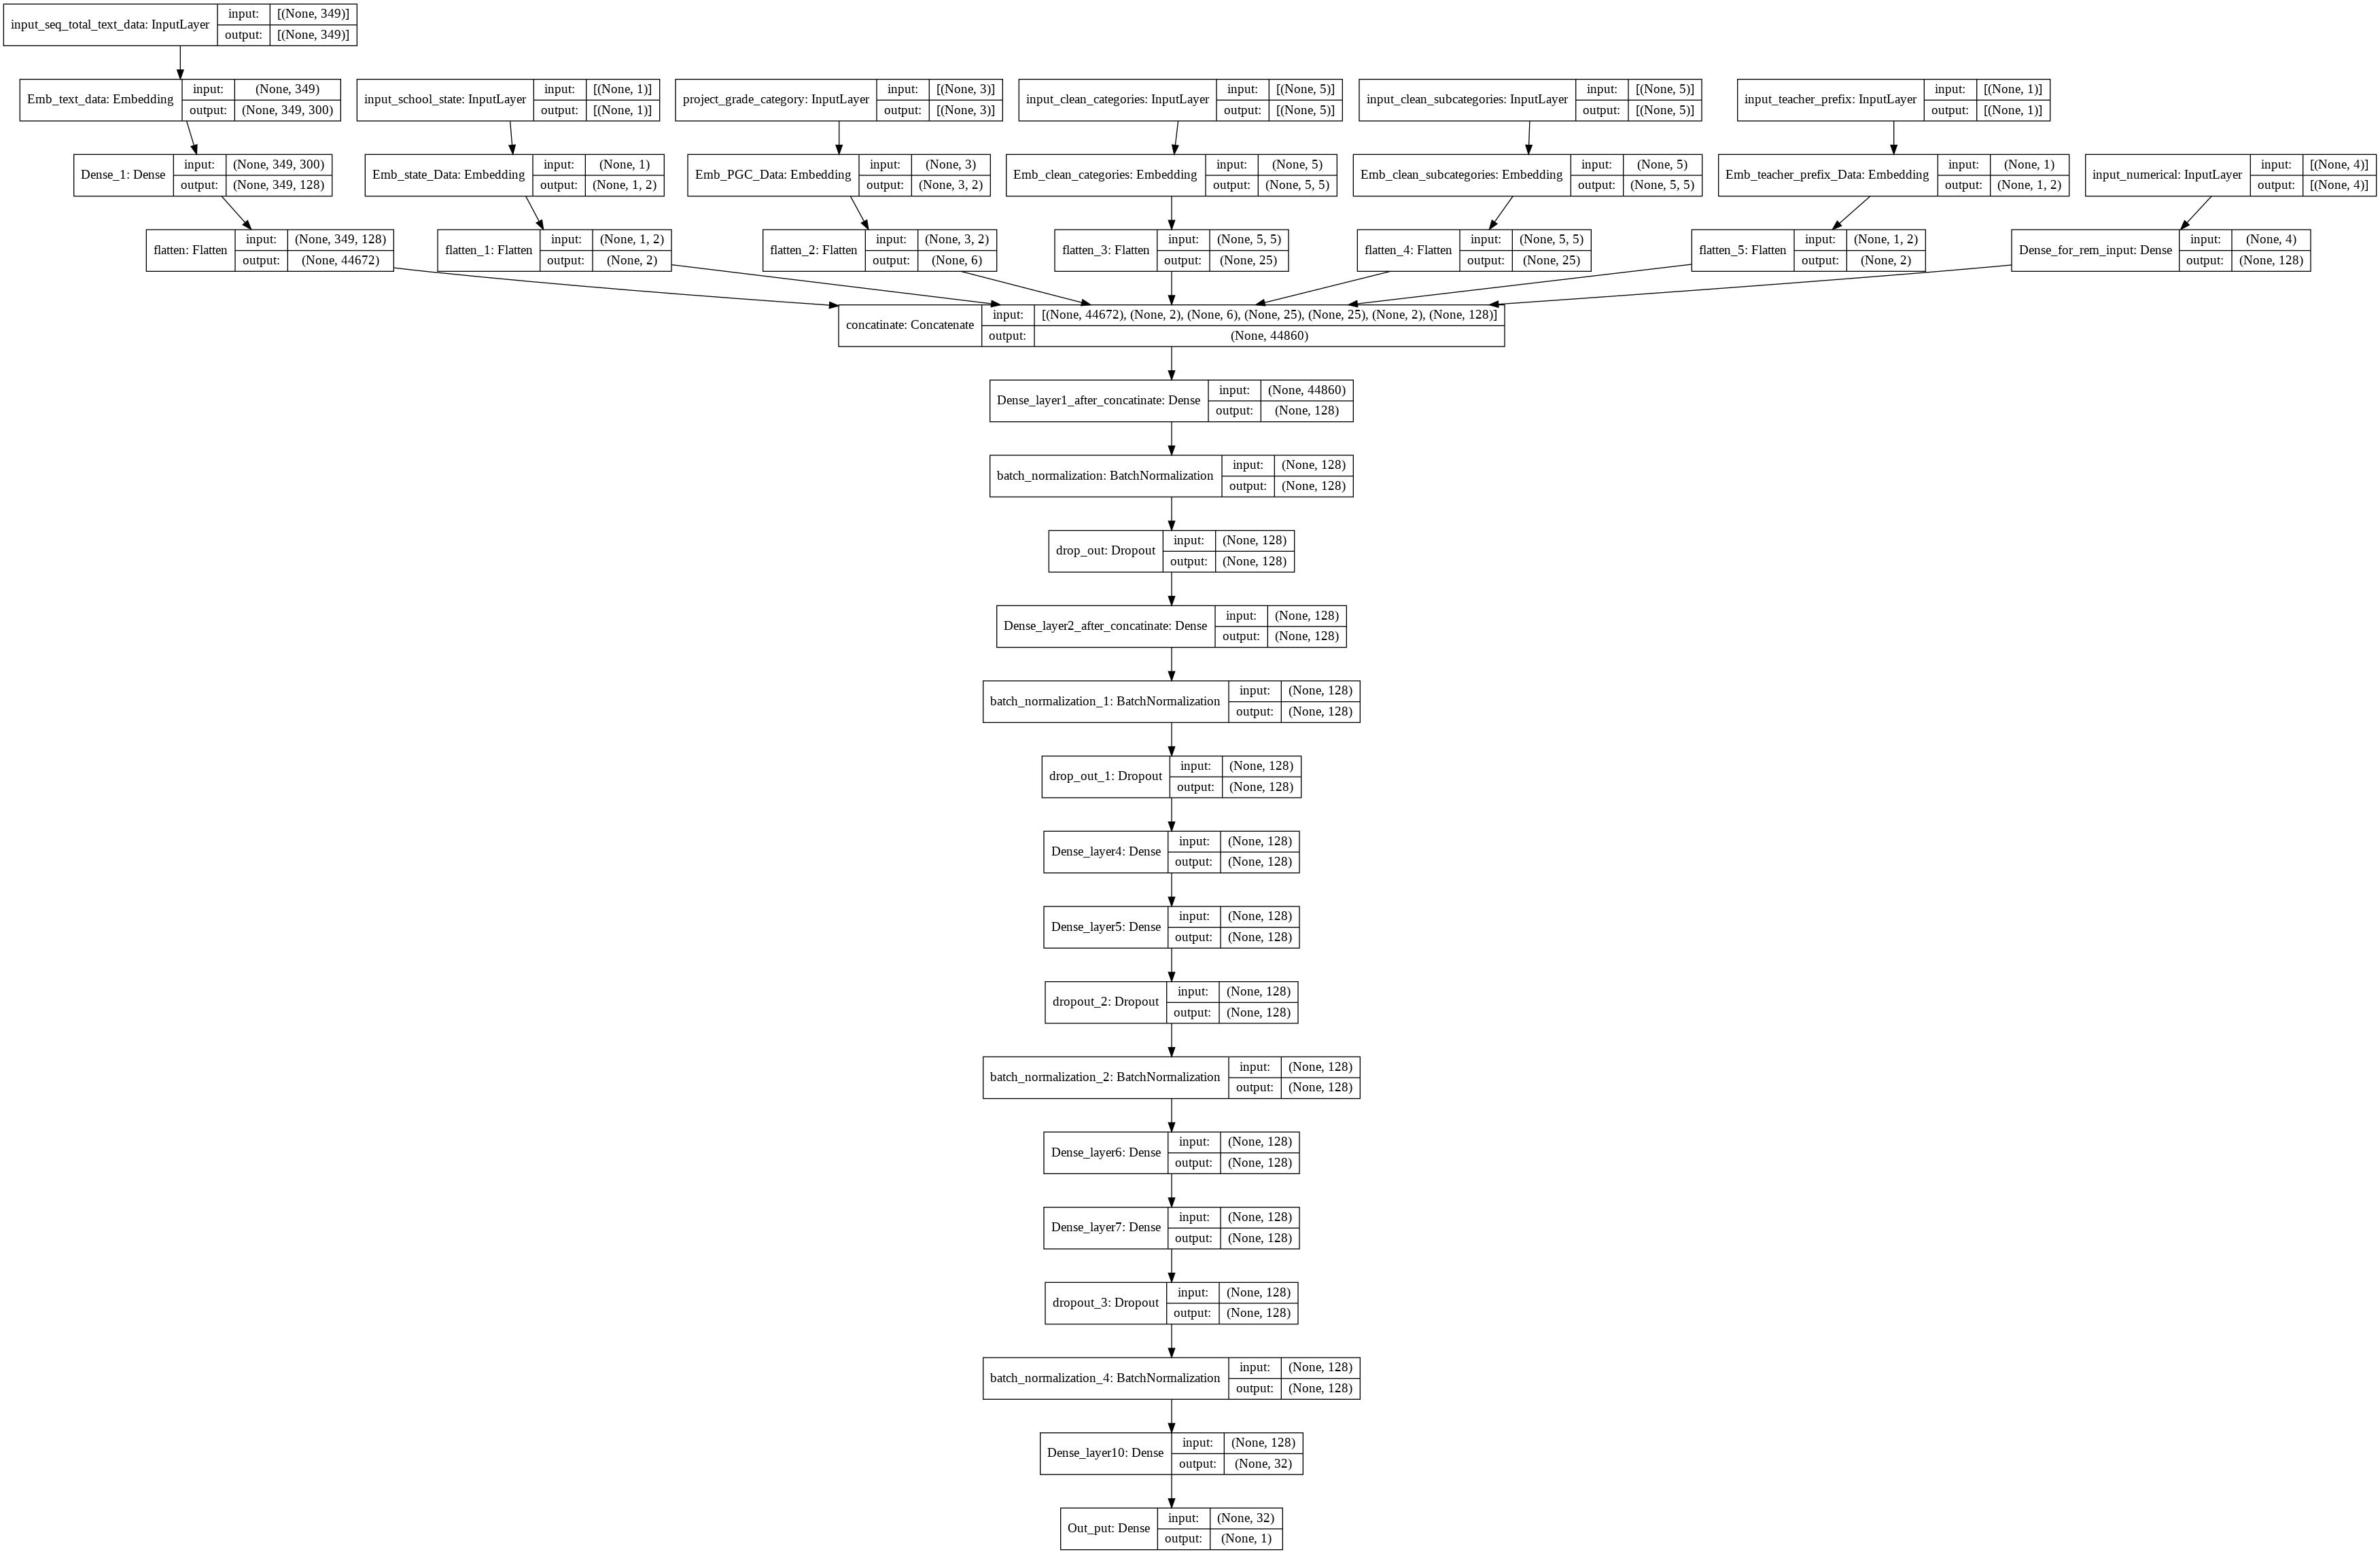

In [38]:
tf.keras.utils.plot_model(model,'model_1.png',show_shapes=True)

In [39]:
callback_list = [history_own,earlystop] 
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy',aucroc])

In [40]:
model.fit([X_train_text,X_train_school_state,X_train_grade_category,X_train_subject_categories,X_train_subject_subcategories,X_train_teacher_prefix,X_train_remaining],y_train,epochs=25,batch_size=128,validation_data=([X_cv_text,X_cv_school_state,X_cv_grade_category,X_cv_subject_categories,X_cv_subject_subcategories,X_cv_teacher_prefix,X_cv_remaining],y_cv),callbacks=callback_list)

Epoch 1/25
352/352 [==============================] - 14s 26ms/step - loss: 1.5450 - accuracy: 0.7684 - aucroc: 0.5033 - val_loss: 0.5171 - val_accuracy: 0.8476 - val_aucroc: 0.5220
Epoch 2/25
352/352 [==============================] - 8s 24ms/step - loss: 0.5143 - accuracy: 0.8470 - aucroc: 0.5257 - val_loss: 0.4878 - val_accuracy: 0.8476 - val_aucroc: 0.5536
Epoch 3/25
352/352 [==============================] - 8s 24ms/step - loss: 0.4945 - accuracy: 0.8477 - aucroc: 0.5347 - val_loss: 0.4862 - val_accuracy: 0.8476 - val_aucroc: 0.6397
Epoch 4/25
352/352 [==============================] - 8s 24ms/step - loss: 0.4851 - accuracy: 0.8489 - aucroc: 0.6260 - val_loss: 0.4541 - val_accuracy: 0.8498 - val_aucroc: 0.7269
Epoch 5/25
352/352 [==============================] - 8s 24ms/step - loss: 0.4660 - accuracy: 0.8439 - aucroc: 0.7066 - val_loss: 0.5137 - val_accuracy: 0.8042 - val_aucroc: 0.7120
Epoch 6/25
352/352 [==============================] - 8s 24ms/step - loss: 0.4415 - accuracy: 

In [41]:
yp=model.predict([X_test_text,X_test_school_state,X_test_grade_category,X_test_subject_categories,X_test_subject_subcategories,X_test_teacher_prefix,X_test_remaining])
print('AucRoc on Test data : ',roc_auc_score(y_test,yp))

AucRoc on Test data :  0.7387735743597175


In [42]:
yp=model.predict([X_train_text,X_train_school_state,X_train_grade_category,X_train_subject_categories,X_train_subject_subcategories,X_train_teacher_prefix,X_train_remaining])
print('AucRoc on Train data : ',roc_auc_score(y_train,yp))

yp=model.predict([X_cv_text,X_cv_school_state,X_cv_grade_category,X_cv_subject_categories,X_cv_subject_subcategories,X_cv_teacher_prefix,X_cv_remaining])
print('AucRoc on Cv data : ',roc_auc_score(y_cv,yp))

AucRoc on Train data :  0.8155978054654447
AucRoc on Cv data :  0.7398755355556959


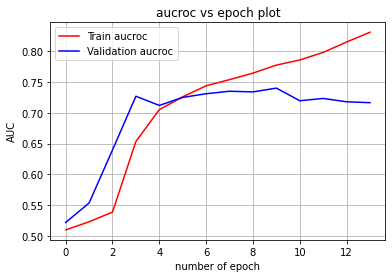

In [43]:
plt.plot(history_own.history['auc'], 'r')
plt.plot(history_own.history['val_aucroc'], 'b')
plt.legend({'Train aucroc': 'r', 'Validation aucroc':'b'})
plt.ylabel('AUC')
plt.xlabel('number of epoch')
plt.title('aucroc vs epoch plot')
plt.grid()
plt.show()

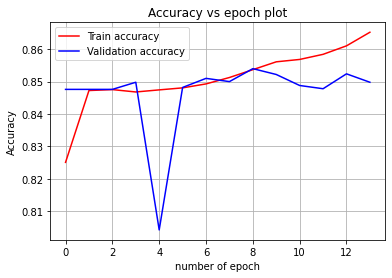

In [44]:
plt.plot(history_own.history['acc'], 'r')
plt.plot(history_own.history['val_acc'], 'b')
plt.legend({'Train accuracy': 'r', 'Validation accuracy':'b'})
plt.ylabel('Accuracy')
plt.xlabel('number of epoch')
plt.title('Accuracy vs epoch plot')
plt.grid()
plt.show()

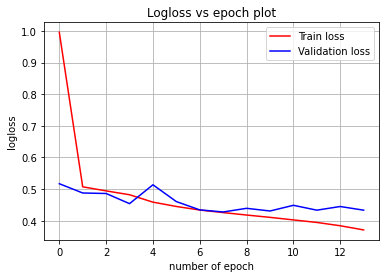

In [45]:
plt.plot(history_own.history['loss'], 'r')
plt.plot(history_own.history['val_loss'], 'b')
plt.legend({'Train loss': 'r', 'Validation loss':'b'})
plt.ylabel('logloss')
plt.xlabel('number of epoch')
plt.title('Logloss vs epoch plot')
plt.grid()
plt.show()

In [46]:
model.save('/content/drive/My Drive/ Deep learning assignments/ LSTM Donors_choose/Model-1.h5')